In [27]:
import csv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import keras_tuner

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [28]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [29]:
train_dataset = image_dataset_from_directory(
    "data/train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "data/val",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    "data/test",
    image_size=(180, 180),
    batch_size=32)

Found 8819 files belonging to 15 classes.
Found 1891 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.


## Balanceo de clases

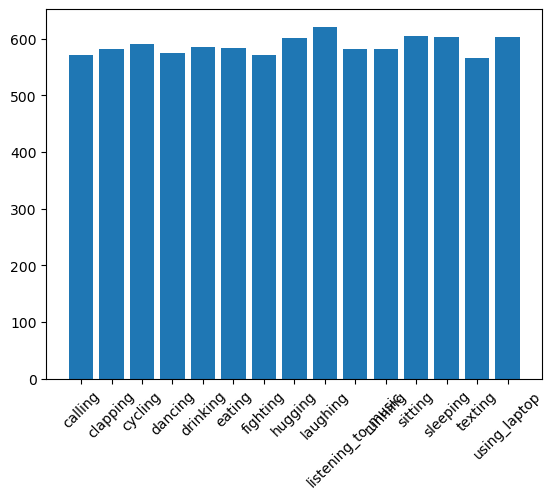

In [30]:
# Obtener las clases
classes = train_dataset.class_names

# Contar las imágenes por clase
count = {}
for c in classes:
    count[c] = len(os.listdir(f"data/train/{c}"))
    
# Graficar
plt.bar(count.keys(), count.values())
plt.xticks(rotation=45)
plt.show()

In [31]:
# Convertir a escala de grises
train_dataset_gray = train_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
validation_dataset_gray = validation_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

In [32]:
# Verificar la forma de las imágenes
for images, labels in train_dataset_gray.take(1):
    print(f"Forma de las imágenes en escala de grises: {images.shape}")

Forma de las imágenes en escala de grises: (32, 180, 180, 1)


In [33]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

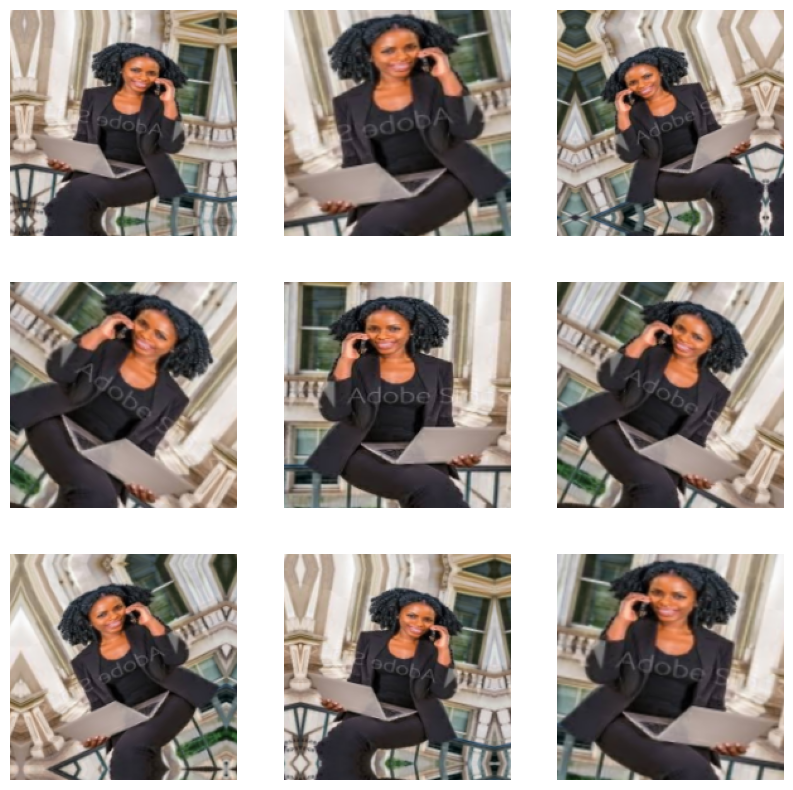

In [34]:
# Muestra imágenes con y sin aumento de datos
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [35]:
'''
def build_model(hp):
    inputs = keras.Input(shape=(180, 180, 3))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    # Bloque 1
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Bloque 2
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Bloque 3
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Bloque 4
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Bloque 5
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)

    if hp.Boolean("dropout"):
        x = layers.Dropout(0.5)(x)  # Dropout fuerte en la parte densa (50%)

    # Capa de salida
    outputs = layers.Dense(15, activation="softmax")(x)

    # Definir el modelo
    model = keras.Model(inputs=inputs, outputs=outputs)

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # Compilar el modelo
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model
'''

'\ndef build_model(hp):\n    inputs = keras.Input(shape=(180, 180, 3))\n    x = data_augmentation(inputs)\n    x = layers.Rescaling(1./255)(x)\n\n    # Bloque 1\n    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)\n    x = layers.MaxPooling2D(pool_size=2)(x)\n\n    # Bloque 2\n    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)\n    x = layers.MaxPooling2D(pool_size=2)(x)\n\n    # Bloque 3\n    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)\n    x = layers.MaxPooling2D(pool_size=2)(x)\n\n    # Bloque 4\n    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)\n    x = layers.MaxPooling2D(pool_size=2)(x)\n\n    # Bloque 5\n    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)\n    x = layers.Flatten()(x)\n\n    if hp.Boolean("dropout"):\n        x = layers.Dropout(0.5)(x)  # Dropout fuerte en la parte densa (50%)\n\n    # Capa de salida\n    outputs = layers.Dense(15, activation="softmax")(x)\n\n

In [36]:
def build_model(hp):
    inputs = keras.Input(shape=(180, 180, 3))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    # Número de bloques convolucionales como hiperparámetro
    num_blocks = hp.Int("num_blocks", min_value=3, max_value=5)
    for i in range(num_blocks):
        x = layers.Conv2D(filters=hp.Int(f"filters_{i}", min_value=32, max_value=256, step=32),
                          kernel_size=hp.Choice(f"kernel_size_{i}", values=[3, 5]),
                          activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Flatten()(x)

    # Capa densa opcional
    if hp.Boolean("dense_layer"):
        x = layers.Dense(hp.Int("dense_units", min_value=64, max_value=256, step=64),
                         activation="relu")(x)

    # Dropout con tasa variable
    if hp.Boolean("dropout"):
        x = layers.Dropout(hp.Float("dropout_rate", min_value=0.2, max_value=0.5, step=0.1))(x)

    outputs = layers.Dense(15, activation="softmax")(x)

    # Optimizer y learning rate
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = hp.Choice("optimizer", ["adam", "sgd", "rmsprop"])

    if optimizer == "adam":
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer == "rmsprop":
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [37]:
model = build_model(keras_tuner.HyperParameters())

In [38]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 87, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 41, 41, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │       192,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,407 (825.81 KB)

 Trainable params: 211,407 (825.81 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Entrenar el modelo
#history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset)

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="/home/luciano/Documentos/Facultad/4to/2_semestre/Inteligencia_Artificial_2/ia2-uncuyo-2024/human-action-recognition/humanActionRecognition/models",
    project_name="HumanActionRecognition",
)

tuner.search(train_dataset, epochs=50, validation_data=validation_dataset)

Trial 3 Complete [01h 17m 22s]
val_accuracy: 0.457694336771965

Best val_accuracy So Far: 0.457694336771965
Total elapsed time: 06h 18m 59s


In [40]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 176, 176, 96)   │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 88, 88, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 86, 86, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 39, 39, 192)    │       460,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 17, 192)    │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 160)      │       276,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1440)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        21,615 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,181,551 (4.51 MB)

 Trainable params: 1,181,551 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
tuner.results_summary()

Results summary
Results in /home/luciano/Documentos/Facultad/4to/2_semestre/Inteligencia_Artificial_2/ia2-uncuyo-2024/human-action-recognition/humanActionRecognition/models/HumanActionRecognition
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
num_blocks: 5
filters_0: 96
kernel_size_0: 5
filters_1: 96
kernel_size_1: 3
filters_2: 192
kernel_size_2: 5
dense_layer: False
dropout: False
lr: 0.0011037353035334538
optimizer: rmsprop
filters_3: 192
kernel_size_3: 3
dense_units: 64
filters_4: 160
kernel_size_4: 3
Score: 0.457694336771965

Trial 1 summary
Hyperparameters:
num_blocks: 5
filters_0: 224
kernel_size_0: 3
filters_1: 256
kernel_size_1: 3
filters_2: 96
kernel_size_2: 3
dense_layer: False
dropout: False
lr: 0.008399696745250233
optimizer: rmsprop
filters_3: 32
kernel_size_3: 3
dense_units: 128
filters_4: 32
kernel_size_4: 3
Score: 0.07403489947319031

Trial 0 summary
Hyperparameters:
num_blocks: 4
filters_0: 160
kernel_size_0: 5


In [42]:
# Plot training history
'''
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()
'''

"\nplt.plot(history.history['accuracy'], label='accuracy')\nplt.plot(history.history['val_accuracy'], label = 'val_accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.ylim([0, 1])\nplt.legend(loc='lower right')\nplt.show()\n"

In [43]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


W0000 00:00:1734224522.790263   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224522.794072   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224522.798386   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224522.804645   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224522.810103   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224522.815641   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224522.821904   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224522.828720   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224522.834402   27058 gp

 6/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0507 - loss: 2.7147

W0000 00:00:1734224523.198006   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224523.200591   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224523.202657   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224523.205065   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224523.207701   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224523.209900   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224523.212161   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224523.214488   27058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224523.217918   27058 gp

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0511 - loss: 2.7158
Test loss: 2.717846632003784
Test accuracy: 0.05502645671367645


W0000 00:00:1734224524.264480   27055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224524.266185   27055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224524.268221   27055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224524.269959   27055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224524.271671   27055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224524.273382   27055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224524.275161   27055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224524.276901   27055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734224524.278640   27055 gp

In [44]:
# Guardar el modelo
#model.save("/home/luciano/Documentos/Facultad/4to/2_semestre/Inteligencia_Artificial_2/ia2-uncuyo-2024/human-action-recognition/humanActionRecognition/models/model02.keras")